# Imports and def

## Imports

In [71]:
import collections
import importlib
import inspect
import glob
import gzip
import os
import pathlib
import re
import sys


import itertools as itt
import pandas as pd
import numpy as np

import scipy.stats
import sklearn

from IPython.display import display

In [2]:
# for comparing cluster results from different clustering methods / runs
import clusim
import clusim.sim
from clusim.clustering import Clustering, print_clustering

In [3]:
import sklearn
import sklearn.preprocessing
import sklearn.metrics

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = "../../../code/pydea"
if not path in sys.path:
    sys.path.insert(0, path)

import pyDEA
importlib.reload(pyDEA)

NameError: name 'importlib' is not defined

In [20]:
path = "/home/icb/lambert.moyon/projects/pyutils/"
if not path in sys.path:
    sys.path.insert(0, path)

import pyutils.misc
importlib.reload(pyutils.misc)

import pyutils.plotting
importlib.reload(pyutils.plotting)

import pyutils.clustering
importlib.reload(pyutils.clustering)

import pyutils.ML_visualization
importlib.reload(pyutils.ML_visualization)

<module 'pyutils.ML_visualization' from '/home/icb/lambert.moyon/projects/pyutils/pyutils/ML_visualization.py'>

In [21]:
path = "../../../code/"
if not path in sys.path:
    sys.path.insert(0, path)

import lib_misc
importlib.reload(lib_misc)

<module 'lib_misc' from '../../../code/lib_misc.py'>

## Definitions

In [151]:
for cluster, cluster_df in E14_ICM_clusters.tbl_annotated.groupby('cluster'):
    print(cluster, cluster_df.shape)

0 (62, 4)
1 (23, 4)
2 (14, 4)
3 (67, 4)
4 (107, 4)
5 (26, 4)
6 (13, 4)
7 (3, 4)
8 (12, 4)


In [8]:
class CmapBuilder:
    full_range_vmin_vmax = list(range(-12,12+1, 2))

    colors = [
        '#3b0084', # Purple (cold) -12
        '#2502b4', # Darker blue -10
        '#1b3cf7', # Dark Blue -8
        '#1d74f7', # blue -6
        '#1bbdf7', # light blue -4
        '#1cf7f7', # light cyan -2
        '#F8FBEC', # "cream", center 0
        '#ffc742', # light yellow 2
        '#eb7a41', # orange 4
        '#ea5b0e', # Brighter orange 6
        '#d33209', # Red 8
        '#9e0000', # Dark Red 10
        '#5b0029', # Dark purple 12
    ]


    def get_cmap_minmax(self, vmin, vmax):
        """Return a cmap with controled, discrete levels colored.

        vmin and vmax determine the number of levels to get.
        To make sure the colormap is symetric, you should provide values such that abs(vmin) = (vmax)
        """
        array_colors = pd.Series(self.colors, index=self.full_range_vmin_vmax)
        sub_colors = array_colors.loc[vmin:vmax]
        print(f"Cmap returned range: [{sub_colors.index.min()} ; {sub_colors.index.max()}]")
        my_cmap = mpl.colors.LinearSegmentedColormap.from_list("", sns.color_palette(sub_colors))
        return my_cmap

In [152]:
class ClusteredTable:

    """
    """

    def __init__(self, tbl, clusters, colors_clusters, DE_genes=None):
        """
        """
        self.tbl = tbl
        self.clusters = clusters
        self.colors_clusters = colors_clusters

        # Do the merging of clusters and tbl directly.
        self.tbl_annotated = pd.merge(self.tbl,
                                       self.clusters.rename('cluster').to_frame(),
                                       left_index=True, right_index=True
                                       )

        self.DE_genes = DE_genes



    def print_min_max(self):
        """Print min and max values over the entire table.
        """
        print(f"Min value over the table: {self.tbl.min().min()}")
        print(f"Max value over the table: {self.tbl.max().max()}")


    def _summarize_cluster_row(self, row):
        if all(row>0):
            return "positive"
        elif all(row<=0):
            return "negative"
        else:
            return "discordant"


    def summarize_clusters(self, DE_genes=None):
        """

        Args:
            DE_genes (list) : if provided, the content of each cluster is compared against this list,
                and a column <N_DE_anyComparison> will report the overlap for each cluster.

        Returns:
            pd.DataFrame

        """

        if DE_genes is None:
            DE_genes = self.DE_genes

        cluster_summarized = []

        # mean value evaluation
        mean = self.tbl_annotated.groupby('cluster').mean().add_prefix('mean.')
        mean['mean_profile'] = mean.apply(lambda row: self._summarize_cluster_row(row), axis=1)

        cluster_summarized.append(mean)

        # Size
        N_tot = self.tbl_annotated.groupby('cluster').size().rename("N_tot")
        cluster_summarized.append(N_tot)

        # N DE miRNA (any comparison)
        if DE_genes is not None:
            N_DE_any = self.tbl_annotated.assign(DE_any=self.tbl_annotated.index.isin(DE_genes)
                                                 ).groupby('cluster')['DE_any'].sum(
                                                 ).rename('N_DE_anyComparison').astype(int)
            cluster_summarized.append(N_DE_any)


        cluster_summarized = pd.concat(cluster_summarized, axis=1)
        return cluster_summarized


    def plot_heatmap(self,
                     col_linkage=None,
                     row_clusters=True,
                     my_cmap=None,
                     savefigfile=None,
                     kwargs_heatmap=None
                    ):
        """Display a heatmap with clusters.
        """
        if my_cmap is None:
            my_cmap = "vlag"

        if kwargs_heatmap is None:
            kwargs_heatmap = {}

        col_cluster = False if col_linkage is None else True

        g = sns.clustermap(self.tbl.T,
                           col_cluster=col_cluster,
                           col_linkage=col_linkage,
                           row_cluster=row_clusters,
                           xticklabels=False,
                           figsize=(16, 6),
                           cmap=my_cmap,
                           center=0,
                           col_colors=self.clusters.map(self.colors_clusters).values,
                           **kwargs_heatmap
                          )

        # show border of the heatmap
        for _, spine in g.ax_heatmap.spines.items():
            spine.set_visible(True)


        # This block allows for adding a legend of the cluster colors.
        for label, color in self.colors_clusters.items():
            g.ax_col_dendrogram.bar(0, 0,
                                    color=color,
                                    label=label,
                                    linewidth=0)

        g.ax_col_dendrogram.legend(loc="center", ncol=6)

        # If you want to keep the yticklabels, here is the command to reduce fontsize.
        _ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 8)

        if savefigfile is not None:
            plt.savefig(savefigfile)

        plt.show()



    def export_data(self, parent_directory: pathlib.Path, suffix=None):
        if not parent_directory.exists():
            parent_directory.mkdir()

        if suffix is not None:
            suffix = f".{suffix}"
        else:
            suffix = ""

        # Export the table of values used for the heatmap display
        path_tbl_clusters = parent_directory / f"table_w_annotated_clusters{suffix}.tsv"
        print(path_tbl_clusters)
        self.tbl_annotated.to_csv(path_tbl_clusters,
                                  header=True,
                                  index=True,
                                  sep="\t",
                                 )

        # export for each cluster the sub-table
        per_cluster_dir = parent_directory / f"per_cluster_table{suffix}"
        if not per_cluster_dir.exists():
            per_cluster_dir.mkdir()

        for cluster, sub_tbl in self.tbl_annotated.groupby('cluster'):
            path_tbl_clust = per_cluster_dir / f"cluster_{cluster}.table{suffix}.tsv"
            print(path_tbl_clust)
            sub_tbl.to_csv(path_tbl_clust,
                          header=True,
                          index=True,
                          sep="\t",
                         )

        # Export the summary table
        summary_table = self.summarize_clusters()
        path_summary_tbl = parent_directory / f"summary_table{suffix}.tsv"
        print(path_summary_tbl)
        summary_table.to_csv(path_summary_tbl,
                          header=True,
                          index=True,
                          sep="\t",
                         )




In [10]:
class ClusteringExperiment:

    n_clusters = range(2,30)

    def __init__(self, table, metric='euclidean', method='ward'):
        self.table = table
        self.metric = metric
        self.method = method

        if not self.table.shape[0] > self.table.shape[1]:
            raise ValueError("Table is expected to be in long format ; clustering will be done on rows.")

        # Linkage of rows
        self.distanceMatrix = scipy.spatial.distance.pdist(self.table, metric=self.metric)
        self.linkage = scipy.cluster.hierarchy.linkage(self.distanceMatrix, method=self.method)

        # Explore multiple cuts on the three
        self.results = pyutils.clustering.hierarchical_clustering_cut_tree(self.table,
                                                                           self.linkage,
                                                                           self.n_clusters)
        # Extract the silhouette scores
        self.silhouettes = self.results['silhouettes'].rename('silhouette').to_frame()

        # Unset N clusters
        self.selected_N_clusters = None

    @property
    def selected_cluster_labels(self):
        if not self.selected_N_clusters:
            raise ValueError("<self.selected_N_clusters> is not set!")

        tmp = self.results['cluster_labels'][self.selected_N_clusters]
        tmp.index = self.table.index.values
        return tmp

    @property
    def colors_clusters(self):
        # To try and track cluster correspondance between different experiments, clusters are sorted by size
        # and assigned a color.
        # It is likely that the largest clusters will match from one experiment to another.
        if not self.selected_N_clusters:
            raise ValueError("<self.selected_N_clusters> is not set!")

        colors_clusters = dict(zip(sorted(self.selected_cluster_labels.unique(),
                                          key=lambda v: list(self.selected_cluster_labels.value_counts().index).index(v)),
                                   [mpl.colors.rgb2hex(c) for c in sns.color_palette(palette="tab20",
                                                                                     n_colors=self.selected_N_clusters)
                                    ]))

        colors_clusters = {k:colors_clusters[k] for k in sorted(colors_clusters.keys())}
        return colors_clusters


    def plot_silhouettes(self, title=None, savefig_file=None):
        if title is None:
            title = f"HC ; {self.metric} ; {self.method}"

        ax1 = pyutils.clustering.plot_silhouettes(self.silhouettes,
                                                  title=title,
                                                  ax=None,
                                                  show_plot=False)

        if self.selected_N_clusters:
            ax1.axvline(self.selected_N_clusters-2,linestyle='--',color='#BBBBBB')

        if savefig_file:
            plt.savefig(savefig_file)

        plt.show()

In [11]:
def cluster_heatmap(X,
                    linkage,
                    clusters,
                    colors_clusters, my_cmap=None, savefigfile=None):
    """Display a heatmap with clusters.

    Args:
        X (pandas.DataFrame) :
    """
    if my_cmap is None:
        my_cmap = "vlag"

    g = sns.clustermap(X.T,
                       col_linkage=linkage,
                       row_cluster=True,
                       xticklabels=False,
                       figsize=(16, 6),
                       cmap=my_cmap,
                       center=0,
                       col_colors=clusters.map(colors_clusters).values
                      )

    # show border of the heatmap
    for _, spine in g.ax_heatmap.spines.items():
        spine.set_visible(True)


    # This block allows for adding a legend of the cluster colors.
    for label in colors_clusters.keys():
        g.ax_col_dendrogram.bar(0, 0, color=colors_clusters[label],
                                label=label, linewidth=0)

    g.ax_col_dendrogram.legend(loc="center", ncol=6)

    # If you want to keep the yticklabels, here is the command to reduce fontsize.
    _ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 8)

    if savefigfile is not None:
        plt.savefig(savefigfile)

    plt.show()

# Load

In [12]:
DATASETS = pyutils.misc.recursive_defaultdict()

## Misc

In [13]:
thresholds = {
    'nanostring':{
        'LFC':0.5849,
        'pval':0.1
    },
    'ivv':{
        'LFC':0.5849,
        'pval':0.05
    },
    'ivt':{
        'LFC':0.5849,
        'pval':0.05
    },
}

## ivv / ivt datasets

Here we load :

- raw quantification from miRBase + miRDeep2
- DESeq2 based normalization
- DESeq2 DEA

### IVT results

#### Raw counts dataset and metadata

Quantification was performed with samples from IVT and IVV experiments taken altogether, as it does not impact the miRDeep2 quantification (samples are quantified independently), while it speeds up the process.

In [14]:
# Metadata table to map column IDs to samples
path = "../../miRNA_ivv_ivt_DEA/datasets/metadata.tsv"
DATASETS['miRDeep2']['metadata'] = pd.read_csv(path,
                                                sep='\t',
                                                header=0,
                                               index_col=0

                                               )
display(DATASETS['miRDeep2']['metadata'])

,id,sample,celltype,condition,replicate,experiment,cond_ct
index,,,,,,,
0,tw1,wtTS1,TS,wt,R1,ivt,wt_TS
1,tp1,pausedTS1,TS,paused,R1,ivt,paused_TS
2,tw2,wtTS2,TS,wt,R2,ivt,wt_TS
3,tp2,pausedTS2,TS,paused,R2,ivt,paused_TS
4,tw3,wtTS3,TS,wt,R3,ivt,wt_TS
5,tp3,pausedTS3,TS,paused,R3,ivt,paused_TS
6,ew1,wtE141,E14,wt,R1,ivt,wt_E14
7,ep1,pausedE141,E14,paused,R1,ivt,paused_E14
8,ew2,wtE142,E14,wt,R2,ivt,wt_E14


In [22]:
# raw counts
path = "../../miRNA_ivv_ivt_DEA/datasets/raw_counts_noDup_FULL.tsv"
tbl = pd.read_csv(path,
                    sep='\t',
                    header=0,
                   )
tbl.columns = [tbl.columns[0].strip('#')] + list(tbl.columns[1:])
display(tbl.head(3))

print(f"N lines : {tbl.shape[0]:,} ; N uniqe miRNAs: {tbl['miRNA'].unique().shape[0]:,}")

DATASETS['miRDeep2']['raw_cts'] = tbl.set_index('miRNA')

,miRNA,di1,di2,di3,dt1,dt2,dt3,mi1,mi2,mi3,...,tw2,tp2,tw3,tp3,ew1,ep1,ew2,ep2,ew3,ep3
0,mmu-let-7a-1-3p,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,mmu-let-7a-2-3p,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,mmu-let-7b-5p,71,32,55,35,171,49,18,14,97,...,1,0,0,1,0,0,2,0,0,0


N lines : 1,978 ; N uniqe miRNAs: 1,978


#### Combined cell-types

In [23]:
sample_dirname = "ivt_samples"

##### raw counts

In [24]:
# raw counts
path = f"../../miRNA_ivv_ivt_DEA/results/{sample_dirname}/noThreshold/results/all_counts_merged_raw.tsv"
tbl = pd.read_csv(path,
                  sep='\t',
                  header=0,
                 )
tbl.columns = [tbl.columns[0].strip('#')] + list(tbl.columns[1:])
display(tbl.head(3))

print(f"N lines : {tbl.shape[0]:,} ; N uniqe miRNAs: {tbl.index.unique().shape[0]:,}")

DATASETS['miRDeep2'][sample_dirname]['combined']['raw_cts'] = tbl

,tw1,tp1,tw2,tp2,tw3,tp3,ew1,ep1,ew2,ep2,ew3,ep3
mmu-let-7b-5p,29,0,1,0,0,1,0,0,2,0,0,0
mmu-let-7d-5p,77,9,15,11,21,26,1,3,0,5,1,3
mmu-let-7d-3p,22,0,3,0,3,3,0,0,1,0,0,1


N lines : 564 ; N uniqe miRNAs: 564


##### normalized counts

In [25]:
# norm counts
path = f"../../miRNA_ivv_ivt_DEA/results/{sample_dirname}/noThreshold/results/all_counts_merged_rlog.tsv"
tbl = pd.read_csv(path,
                  sep='\t',
                  header=0,
                 )
tbl.columns = [tbl.columns[0].strip('#')] + list(tbl.columns[1:])
display(tbl.head(3))

print(f"N lines : {tbl.shape[0]:,} ; N uniqe miRNAs: {tbl.index.unique().shape[0]:,}")

DATASETS['miRDeep2'][sample_dirname]['combined']['norm_cts'] = tbl

,tw1,tp1,tw2,tp2,tw3,tp3,ew1,ep1,ew2,ep2,ew3,ep3
mmu-let-7b-5p,1.781843,-1.509606,-0.217063,-1.661816,-1.309258,-1.095884,-1.314208,-1.998948,0.929056,-1.924713,-1.161230,-1.503950
mmu-let-7d-5p,4.268367,3.207493,4.154972,3.152159,4.740681,3.318464,1.126599,0.902455,0.344550,1.635814,1.389329,1.869258
mmu-let-7d-3p,1.802312,-1.171820,1.247837,-1.336535,1.352995,0.108223,-0.960367,-1.612989,0.566819,-1.555611,-0.794820,-0.009485


N lines : 564 ; N uniqe miRNAs: 564


##### DEA

In [26]:
# E14
p1_all = ['paused_E14']
p2_all = ["wt_E14"]

for p1, p2 in itt.product(p1_all, p2_all):
    path = f"../../miRNA_ivv_ivt_DEA/results/{sample_dirname}/noThreshold/results/differential-expression-tables/{p1}_VS_{p2}_FC_shrink.tsv"
    dea_res = lib_misc.load_DEA_result(path, p1, p2, thresholds['ivt']['LFC'], thresholds['ivt']['pval'])

    DATASETS['miRDeep2'][sample_dirname]['combined']['DEA'][f"{p1}_VS_{p2}"] = dea_res

In [27]:
# TS
p1_all = ['paused_TS']
p2_all = ["wt_TS"]

for p1, p2 in itt.product(p1_all, p2_all):
    path = f"../../miRNA_ivv_ivt_DEA/results/{sample_dirname}/noThreshold/results/differential-expression-tables/{p1}_VS_{p2}_FC_shrink.tsv"
    dea_res = lib_misc.load_DEA_result(path, p1, p2, thresholds['ivt']['LFC'], thresholds['ivt']['pval'])

    DATASETS['miRDeep2'][sample_dirname]['combined']['DEA'][f"{p1}_VS_{p2}"] = dea_res

### IVV RESULTS

In [28]:
sample_dirname = "ivv_samples"

##### raw counts

In [29]:
# raw counts
path = f"../../miRNA_ivv_ivt_DEA/results/{sample_dirname}/noThreshold/results/all_counts_merged_raw.tsv"
tbl = pd.read_csv(path,
                  sep='\t',
                  header=0,
                 )
tbl.columns = [tbl.columns[0].strip('#')] + list(tbl.columns[1:])
display(tbl.head(3))

print(f"N lines : {tbl.shape[0]:,} ; N uniqe miRNAs: {tbl.index.unique().shape[0]:,}")

DATASETS['miRDeep2'][sample_dirname]['combined']['raw_cts'] = tbl

,di1,di2,di3,dt1,dt2,dt3,mi1,mi2,mi3,mt1,mt2,mt3,wi1,wi2,wt1,wt2
mmu-let-7b-5p,71,32,55,35,171,49,18,14,97,11,20,31,10,24,13,28
mmu-let-7b-3p,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0
mmu-let-7d-5p,58,34,46,34,76,38,2,1,6,9,6,5,0,6,4,3


N lines : 406 ; N uniqe miRNAs: 406


##### normalized counts

In [30]:
# norm counts
path = f"../../miRNA_ivv_ivt_DEA/results/{sample_dirname}/noThreshold/results/all_counts_merged_rlog.tsv"
tbl = pd.read_csv(path,
                  sep='\t',
                  header=0,
                 )
tbl.columns = [tbl.columns[0].strip('#')] + list(tbl.columns[1:])
display(tbl.head(3))

print(f"N lines : {tbl.shape[0]:,} ; N uniqe miRNAs: {tbl.index.unique().shape[0]:,}")

DATASETS['miRDeep2'][sample_dirname]['combined']['norm_cts'] = tbl

,di1,di2,di3,dt1,dt2,dt3,mi1,mi2,mi3,mt1,mt2,mt3,wi1,wi2,wt1,wt2
mmu-let-7b-5p,4.692824,4.298829,4.864385,4.206526,5.555769,4.416406,4.979150,4.975141,7.526721,4.140164,4.975123,5.541160,4.970771,4.822201,3.890027,4.361103
mmu-let-7b-3p,-2.028538,-2.013912,-2.019624,-2.025628,-1.925839,-2.027248,-1.919160,-1.898555,-1.558906,-1.939165,-1.928193,-1.925797,-1.870871,-1.953944,-1.970500,-1.998675
mmu-let-7d-5p,4.025264,3.947315,4.193056,3.779013,4.122780,3.733049,2.537163,2.375420,3.663383,3.503750,3.252238,3.120843,2.093728,2.982120,2.509607,2.077653


N lines : 406 ; N uniqe miRNAs: 406


##### DEA

In [31]:
p1_all = ['diapaused_ICM', 'mTor_ICM']
p2_all = ["wt_ICM"]

for p1, p2 in itt.product(p1_all, p2_all):
    path = f"../../miRNA_ivv_ivt_DEA/results/{sample_dirname}/noThreshold/results/differential-expression-tables/{p1}_VS_{p2}_FC_shrink.tsv"
    dea_res = lib_misc.load_DEA_result(path, p1, p2, thresholds['ivt']['LFC'], thresholds['ivv']['pval'])
    DATASETS['miRDeep2'][sample_dirname]['combined']['DEA'][f"{p1}_VS_{p2}"] = dea_res

In [32]:
p1_all = ['diapaused_TE', 'mTor_TE']
p2_all = ["wt_TE"]


for p1, p2 in itt.product(p1_all, p2_all):
    path = f"../../miRNA_ivv_ivt_DEA/results/{sample_dirname}/noThreshold/results/differential-expression-tables/{p1}_VS_{p2}_FC_shrink.tsv"
    dea_res = lib_misc.load_DEA_result(path, p1, p2, thresholds['ivt']['LFC'], thresholds['ivv']['pval'])

    DATASETS['miRDeep2'][sample_dirname]['combined']['DEA'][f"{p1}_VS_{p2}"] = dea_res

# Clustering and heatmaps

## Exporting results : preparation

In [76]:
parent_directory = "../results/RNAseq-DEA_IVV-IVT_clustering/"
outputdir = pyutils.misc.make_experiment_outputdir(parent_directory)
print(outputdir)

../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45


## Other set-up

In [77]:
CLUSTERINGS = pyutils.misc.recursive_defaultdict()

In [78]:
# Here we define VMIN and VMAX by inspecting all the cluster results.
# This allows to have a unified scale across clustering results figures,
# so a color from one table is comparable to the color of another table.
VMIN_LOGFC = -6
VMAX_LOGFC = 6

## E14 / ICM

In [153]:
outputdir_E14ICM = outputdir / "IVV-IVT_E14-ICM"
if not outputdir_E14ICM.exists():
    outputdir_E14ICM.mkdir()

### Prepare data

In [154]:
tmp_tbls = []
tmp_de_genes = []
tmp_de_genes_table = []

for k in DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'].keys():
    if not "ICM" in k: continue

    dea = DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k]
    tmp_tbl = dea.get_full_table()
    tmp_tbl = tmp_tbl.filter(regex='logFC').rename(columns = {'logFC':k.split('_VS_')[0]})
    tmp_tbls.append(tmp_tbl)

    tmp_de_genes+= list(DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k].get_significant().index.values)
    tmp_de_genes_table.append(DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k].get_significant().assign(comparison=k))

for k in DATASETS['miRDeep2']['ivt_samples']['combined']['DEA'].keys():
    if not "E14" in k: continue

    dea = DATASETS['miRDeep2']['ivt_samples']['combined']['DEA'][k]
    tmp_tbl = dea.get_full_table()
    tmp_tbl = tmp_tbl.filter(regex='logFC').rename(columns = {'logFC':k.split('_VS_')[0]})
    tmp_tbls.append(tmp_tbl)

    tmp_de_genes+= list(DATASETS['miRDeep2']['ivt_samples']['combined']['DEA'][k].get_significant().index.values)
    tmp_de_genes_table.append(DATASETS['miRDeep2']['ivt_samples']['combined']['DEA'][k].get_significant().assign(comparison=k))


full_merge = pd.concat(tmp_tbls, sort=True, axis=1)
print(full_merge.shape[0])
full_merge = full_merge.dropna()
print(f"Number of miRNA successfully merged from the two experiments: {full_merge.shape[0]:,}")

# Remove duplicates and focus on those merged.
DE_genes = set(tmp_de_genes) & set(full_merge.index.values)


tmp_de_genes_table = pd.concat(tmp_de_genes_table)

643
Number of miRNA successfully merged from the two experiments: 327


In [155]:
scaler = sklearn.preprocessing.StandardScaler()
scaled_logFC_sub = scaler.fit_transform(full_merge)
scaled_logFC_sub = pd.DataFrame(scaled_logFC_sub,
                                index = full_merge.index.values,
                                columns = full_merge.columns)

In [156]:
CLUSTERINGS['DESeq2']['IVV_IVT_E14']['raw_logFC'] = full_merge.copy()
CLUSTERINGS['DESeq2']['IVV_IVT_E14']['DE_genes'] = DE_genes
CLUSTERINGS['DESeq2']['IVV_IVT_E14']['scaled_logFC'] = scaled_logFC_sub.copy()
CLUSTERINGS['DESeq2']['IVV_IVT_E14']['DE_genes_table'] = tmp_de_genes_table.copy()

### Clustering

In [157]:
sample_tissue = 'IVV_IVT_E14'
method = 'ward'
metric = 'euclidean'

/home/icb/lambert.moyon/anaconda3/envs/devpause_env/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


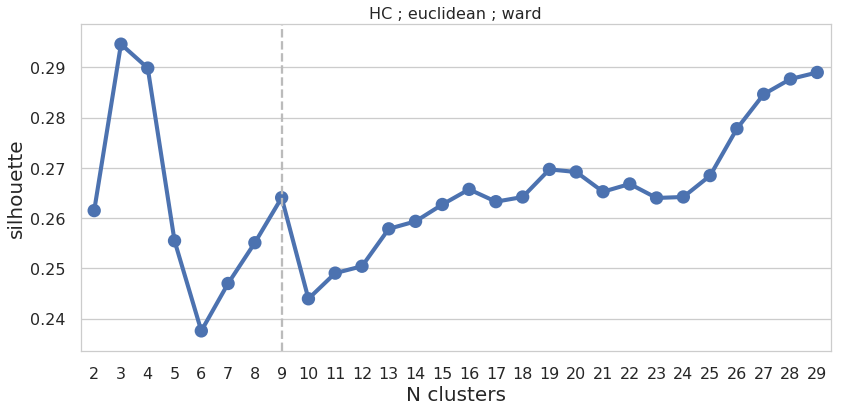

In [158]:
E14_ICM_ClusteringExp = ClusteringExperiment(CLUSTERINGS['DESeq2']['IVV_IVT_E14']['scaled_logFC'],
                                             method=method,
                                             metric=metric)

#E14_ICM_ClusteringExp.plot_silhouettes()
E14_ICM_ClusteringExp.selected_N_clusters = 9

savefig_file = outputdir_E14ICM / "silhouette.svg"
#savefig_file = None
E14_ICM_ClusteringExp.plot_silhouettes(savefig_file=savefig_file)

In [159]:
linkage = E14_ICM_ClusteringExp.linkage
selected_cluster_labels = E14_ICM_ClusteringExp.selected_cluster_labels
colors_clusters = E14_ICM_ClusteringExp.colors_clusters


E14_ICM_clusters = ClusteredTable(CLUSTERINGS['DESeq2']['IVV_IVT_E14']['raw_logFC'],
                                  clusters=selected_cluster_labels,
                                  colors_clusters=colors_clusters
                                  )

# Define a cmap with alternative colors for better highlighting changes in fold changes.
E14_ICM_clusters.print_min_max()
my_cmap = CmapBuilder().get_cmap_minmax(-8,8)

Min value over the table: -5.988283086996269
Max value over the table: 4.06823937599978
Cmap returned range: [-8 ; 8]


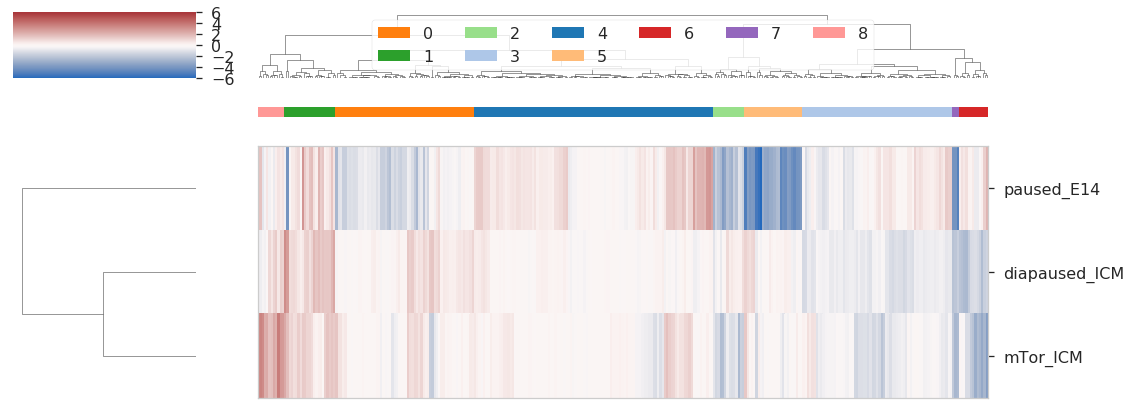

,mean.diapaused_ICM,mean.mTor_ICM,mean.paused_E14,mean_profile,N_tot,N_DE_anyComparison
cluster,,,,,,
0,0.449847,0.135439,-0.863280,discordant,62,2
1,1.481452,1.120591,0.768657,positive,23,1
2,0.185339,-1.430976,-2.248414,discordant,14,5
3,-0.708896,-0.500840,0.107604,discordant,67,0
4,0.049790,0.140059,0.676268,positive,107,1
5,0.237193,-0.055313,-3.944389,discordant,26,12
6,-1.774168,-1.855261,0.467281,discordant,13,1
7,-1.942101,-2.322173,-4.382110,negative,3,3
8,0.476572,2.811007,0.290268,positive,12,1


In [160]:
savefig_file = outputdir_E14ICM / "heatmap_raw-logFC.svg"
#savefig_file = None

E14_ICM_clusters.plot_heatmap(col_linkage=linkage,
                              savefigfile=savefig_file,
                              #my_cmap=my_cmap,
                              kwargs_heatmap={'vmin':VMIN_LOGFC,'vmax':VMAX_LOGFC}
                             )

summary_table = E14_ICM_clusters.summarize_clusters(DE_genes=CLUSTERINGS['DESeq2']['IVV_IVT_E14']['DE_genes'])
display(summary_table)

In [162]:
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['linkage'] = linkage
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['selected_cluster_labels'] = selected_cluster_labels
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['colors_clusters'] = colors_clusters
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['summarized_clusters'] = summary_table.copy()

### Export

In [163]:
# This exports the table used for the heatmap ; the sub-table per cluster ; the summary table.
E14_ICM_clusters.export_data(outputdir_E14ICM, suffix='raw_logFC')

# We also export the scaled logFC values
outputdir_E14ICM_scaled_tbl = outputdir_E14ICM / "table_scaled_logFC_for_clustering.tsv"
CLUSTERINGS['DESeq2']['IVV_IVT_E14']['scaled_logFC'].to_csv(outputdir_E14ICM_scaled_tbl,
                                                            header=True,
                                                            index=True,
                                                            sep="\t"
                                                           )

# And the table of DE miRNAs, aggregated from the different comparisons.
outputdir_E14ICM_DE_genes = outputdir_E14ICM / "table_DE_genes_all_comparisons.tsv"
CLUSTERINGS['DESeq2']['IVV_IVT_E14']['DE_genes_table'].to_csv(outputdir_E14ICM_DE_genes,
                                                              header=True,
                                                              index=True,
                                                              sep="\t"
                                                             )

../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_E14-ICM/table_w_annotated_clusters.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_E14-ICM/per_cluster_table.raw_logFC/cluster_0.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_E14-ICM/per_cluster_table.raw_logFC/cluster_1.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_E14-ICM/per_cluster_table.raw_logFC/cluster_2.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_E14-ICM/per_cluster_table.raw_logFC/cluster_3.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_E14-ICM/per_cluster_table.raw_logFC/cluster_4.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_E14-ICM/per_cluster_table.raw_logFC/cluster_5.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_E14

### Exploring clustering

##### Explore specific cluster

In [305]:
display(clusters_logFC.loc[(tmp["cluster"]==1),:])

,diapaused_ICM,mTor_ICM,paused_E14,cluster
mmu-let-7d-5p,1.994476,0.392090,0.781504,1
mmu-let-7g-5p,1.043283,0.885175,0.542781,1
mmu-miR-141-3p,1.580174,1.674259,0.539699,1
mmu-miR-148a-3p,0.838747,1.161704,1.727824,1
mmu-miR-152-3p,3.369270,2.469559,-0.494827,1
mmu-miR-1839-5p,2.026016,1.597830,1.632651,1
mmu-miR-200a-3p,1.521712,1.449122,0.838676,1
mmu-miR-200b-3p,1.231986,1.415203,1.423348,1
mmu-miR-200b-5p,1.862138,0.391647,2.120523,1
mmu-miR-200c-3p,1.187016,0.978491,1.868178,1


##### Candidate miRNA original values

In [186]:
# Here look at the DE status of a given miRNA of interest.
DATASETS['miRDeep2']['ivt_samples']['combined']['DEA']['paused_E14_VS_wt_E14'].get_full_table().loc[['mmu-miR-200b-5p'],:]

,logFC,pval,padj,DE_status,significant
mmu-miR-200b-5p,2.120523,0.314826,1.0,notSign,False


In [243]:
# Here look at the rlog values of a miRNA of interest
DATASETS['miRDeep2']['ivt_samples']['combined']['norm_cts'].loc[['mmu-miR-200b-5p']]

,tw1,tp1,tw2,tp2,tw3,tp3,ew1,ep1,ew2,ep2,ew3,ep3
mmu-miR-200b-5p,0.622642,-1.027421,0.235676,-0.113156,-0.818341,-1.466125,-0.823506,0.81129,-0.55684,1.276289,0.50274,1.366103


## TS / TE

In [164]:
outputdir_TSTE = outputdir / "IVV-IVT_TS-TE"
if not outputdir_TSTE.exists():
    outputdir_TSTE.mkdir()

### Prepare data

In [165]:
tmp_tbls = []
tmp_de_genes = []
tmp_de_genes_table = []

for k in DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'].keys():
    if not "TE" in k: continue

    dea = DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k]
    tmp_tbl = dea.get_full_table()
    tmp_tbl = tmp_tbl.filter(regex='logFC').rename(columns = {'logFC':k.split('_VS_')[0]})
    tmp_tbls.append(tmp_tbl)

    tmp_de_genes+= list(DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k].get_significant().index.values)
    tmp_de_genes_table.append(DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k].get_significant().assign(comparison=k))


for k in DATASETS['miRDeep2']['ivt_samples']['combined']['DEA'].keys():
    if not "TS" in k: continue

    dea = DATASETS['miRDeep2']['ivt_samples']['combined']['DEA'][k]
    tmp_tbl = dea.get_full_table()
    tmp_tbl = tmp_tbl.filter(regex='logFC').rename(columns = {'logFC':k.split('_VS_')[0]})
    tmp_tbls.append(tmp_tbl)

    tmp_de_genes+= list(DATASETS['miRDeep2']['ivt_samples']['combined']['DEA'][k].get_significant().index.values)
    tmp_de_genes_table.append(DATASETS['miRDeep2']['ivt_samples']['combined']['DEA'][k].get_significant().assign(comparison=k))



full_merge = pd.concat(tmp_tbls, sort=True, axis=1)
print(full_merge.shape[0])
full_merge = full_merge.dropna()
print(f"Number of miRNA successfully merged from the two experiments: {full_merge.shape[0]:,}")

# Remove duplicates and focus on those merged.
DE_genes = set(tmp_de_genes) & set(full_merge.index.values)


tmp_de_genes_table = pd.concat(tmp_de_genes_table)

643
Number of miRNA successfully merged from the two experiments: 327


In [166]:
scaler = sklearn.preprocessing.StandardScaler()
scaled_logFC_sub = scaler.fit_transform(full_merge)
scaled_logFC_sub = pd.DataFrame(scaled_logFC_sub,
                                index = full_merge.index.values,
                                columns = full_merge.columns)

In [167]:
CLUSTERINGS['DESeq2']['IVV_IVT_TS']['raw_logFC'] = full_merge.copy()
CLUSTERINGS['DESeq2']['IVV_IVT_TS']['DE_genes'] = DE_genes
CLUSTERINGS['DESeq2']['IVV_IVT_TS']['DE_genes_table'] = tmp_de_genes_table.copy()
CLUSTERINGS['DESeq2']['IVV_IVT_TS']['scaled_logFC'] = scaled_logFC_sub.copy()

### Clustering

In [168]:
sample_tissue = 'IVV_IVT_TS'
method = 'ward'
metric = 'euclidean'

/home/icb/lambert.moyon/anaconda3/envs/devpause_env/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


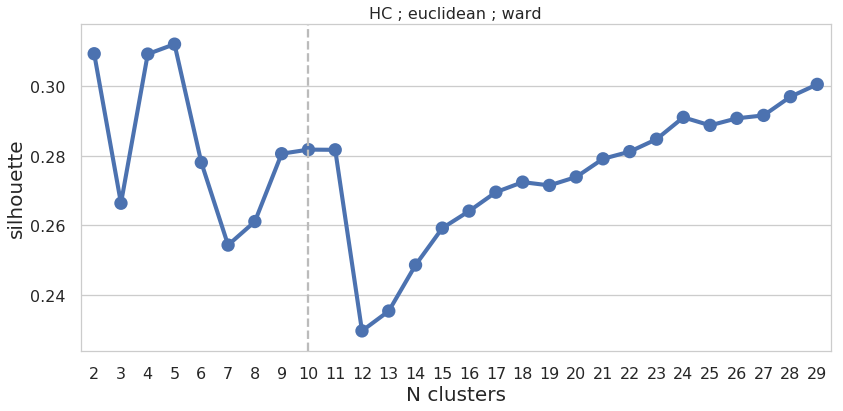

In [169]:
TE_TS_ClusteringExp = ClusteringExperiment(CLUSTERINGS['DESeq2']['IVV_IVT_TS']['scaled_logFC'],
                                           method=method,
                                           metric=metric)

#TE_TS_ClusteringExp.plot_silhouettes()
TE_TS_ClusteringExp.selected_N_clusters = 10

savefig_file = outputdir_TSTE / "silhouette.svg"
#savefig_file = None
TE_TS_ClusteringExp.plot_silhouettes(savefig_file=savefig_file)

In [171]:
linkage = TE_TS_ClusteringExp.linkage
selected_cluster_labels = TE_TS_ClusteringExp.selected_cluster_labels
colors_clusters = TE_TS_ClusteringExp.colors_clusters


TE_TS_clusters = ClusteredTable(CLUSTERINGS['DESeq2']['IVV_IVT_TS']['raw_logFC'],
                                clusters=selected_cluster_labels,
                                colors_clusters=colors_clusters
                                )

# Define a cmap with alternative colors for better highlighting changes in fold changes.
TE_TS_clusters.print_min_max()
my_cmap = CmapBuilder().get_cmap_minmax(-8,8)

Min value over the table: -4.97444586002641
Max value over the table: 3.3540273360999704
Cmap returned range: [-8 ; 8]


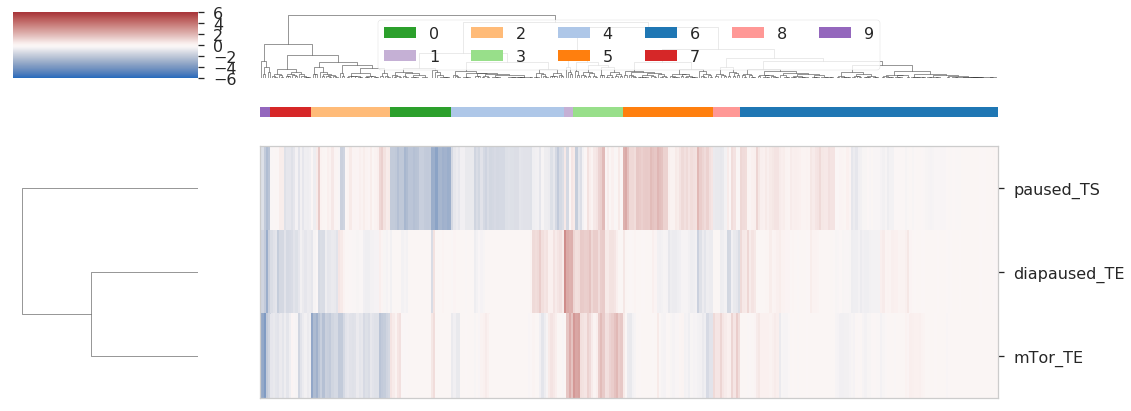

,mean.diapaused_TE,mean.mTor_TE,mean.paused_TS,mean_profile,N_tot,N_DE_anyComparison
cluster,,,,,,
0,-0.064658,0.155397,-2.306848,discordant,27,2
1,2.564999,1.404327,-0.004316,discordant,4,0
2,-0.337964,-1.470314,0.225911,discordant,35,1
3,0.982439,1.341624,0.225553,positive,22,1
4,0.178296,-0.040337,-0.984653,discordant,50,0
5,-0.326718,-0.247845,1.201220,discordant,40,1
6,0.044488,-0.014229,0.104801,discordant,114,0
7,-1.009122,-0.661814,-0.443701,negative,18,0
8,-0.619423,0.783159,-0.172111,discordant,12,0


In [172]:
savefig_file = outputdir_TSTE / "heatmap_raw-logFC.svg"
#savefig_file = None

TE_TS_clusters.plot_heatmap(col_linkage=linkage,
                            savefigfile=savefig_file,
                            #my_cmap=my_cmap,
                            kwargs_heatmap={'vmin':VMIN_LOGFC,'vmax':VMAX_LOGFC}
                            )

summary_table = TE_TS_clusters.summarize_clusters(DE_genes=CLUSTERINGS['DESeq2']['IVV_IVT_TS']['DE_genes'])
display(summary_table)

In [173]:
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['linkage'] = linkage
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['selected_cluster_labels'] = selected_cluster_labels
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['colors_clusters'] = colors_clusters
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['summarized_clusters'] = summary_table.copy()

### Exporting

In [174]:
# This exports the table used for the heatmap ; the sub-table per cluster ; the summary table.
TE_TS_clusters.export_data(outputdir_TSTE, suffix='raw_logFC')

# We also export the scaled logFC values
outputdir_TSTE_scaled_tbl = outputdir_TSTE / "table_scaled_logFC_for_clustering.tsv"
CLUSTERINGS['DESeq2']['IVV_IVT_TS']['scaled_logFC'].to_csv(outputdir_TSTE_scaled_tbl,
                                                            header=True,
                                                            index=True,
                                                            sep="\t"
                                                           )

# And the table of DE miRNAs, aggregated from the different comparisons.
outputdir_TSTE_DE_genes = outputdir_TSTE / "table_DE_genes_all_comparisons.tsv"
CLUSTERINGS['DESeq2']['IVV_IVT_TS']['DE_genes_table'].to_csv(outputdir_TSTE_DE_genes,
                                                              header=True,
                                                              index=True,
                                                              sep="\t"
                                                             )

../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_TS-TE/table_w_annotated_clusters.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_TS-TE/per_cluster_table.raw_logFC/cluster_0.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_TS-TE/per_cluster_table.raw_logFC/cluster_1.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_TS-TE/per_cluster_table.raw_logFC/cluster_2.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_TS-TE/per_cluster_table.raw_logFC/cluster_3.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_TS-TE/per_cluster_table.raw_logFC/cluster_4.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_TS-TE/per_cluster_table.raw_logFC/cluster_5.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV-IVT_TS-TE/per_cluster

## in vivo samples (ICM and TE)

In [175]:
outputdir_IVV = outputdir / "IVV"
if not outputdir_IVV.exists():
    outputdir_IVV.mkdir()

### Prepare dataset

In [176]:
tmp_tbls = []
tmp_de_genes = []
tmp_de_genes_table = []

for k in DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'].keys():
    dea = DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k]
    tmp_tbl = dea.get_full_table()
    tmp_tbl = tmp_tbl.filter(regex='logFC').rename(columns = {'logFC':k.split('_VS_')[0]})
    tmp_tbls.append(tmp_tbl)

    tmp_de_genes+= list(DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k].get_significant().index.values)
    tmp_de_genes_table.append(DATASETS['miRDeep2']['ivv_samples']['combined']['DEA'][k].get_significant().assign(comparison=k))


full_merge = pd.concat(tmp_tbls, axis=1)
print(full_merge.shape[0])
full_merge = full_merge.dropna()
print(full_merge.shape[0])

# Remove duplicates and focus on those merged.
DE_genes = set(tmp_de_genes) & set(full_merge.index.values)


tmp_de_genes_table = pd.concat(tmp_de_genes_table)

406
406


In [177]:
scaler = sklearn.preprocessing.StandardScaler()
scaled_logFC_sub = scaler.fit_transform(full_merge)
scaled_logFC_sub = pd.DataFrame(scaled_logFC_sub,
                                index = full_merge.index.values,
                                columns = full_merge.columns)

In [178]:
CLUSTERINGS['DESeq2']['IVV']['raw_logFC'] = full_merge.copy()
CLUSTERINGS['DESeq2']['IVV']['DE_genes'] = DE_genes
CLUSTERINGS['DESeq2']['IVV']['DE_genes_table'] = tmp_de_genes_table.copy()
CLUSTERINGS['DESeq2']['IVV']['scaled_logFC'] = scaled_logFC_sub.copy()

### Clustering

In [179]:
sample_tissue = 'IVV'
method = 'ward'
metric = 'euclidean'

/home/icb/lambert.moyon/anaconda3/envs/devpause_env/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


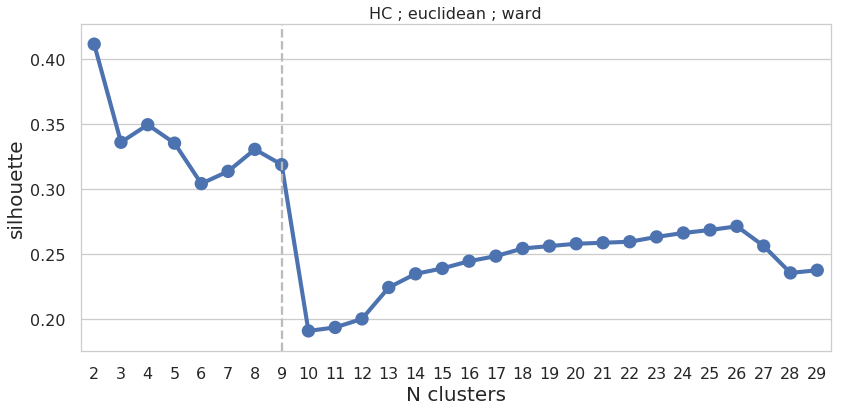

In [180]:
IVV_ClusteringExp = ClusteringExperiment(CLUSTERINGS['DESeq2']['IVV']['scaled_logFC'],
                                         method=method,
                                         metric=metric)

#IVV_ClusteringExp.plot_silhouettes()
IVV_ClusteringExp.selected_N_clusters = 9

savefig_file = outputdir_IVV / "silhouette.svg"
#savefig_file = None
IVV_ClusteringExp.plot_silhouettes(savefig_file= savefig_file)

In [181]:
linkage = IVV_ClusteringExp.linkage
selected_cluster_labels = IVV_ClusteringExp.selected_cluster_labels
colors_clusters = IVV_ClusteringExp.colors_clusters



IVV_clusters = ClusteredTable(CLUSTERINGS['DESeq2']['IVV']['raw_logFC'],
                              clusters=selected_cluster_labels,
                              colors_clusters=colors_clusters,
                              )

IVV_clusters.print_min_max()
my_cmap = CmapBuilder().get_cmap_minmax(-6,6)

Min value over the table: -4.97444586002641
Max value over the table: 4.06823937599978
Cmap returned range: [-6 ; 6]


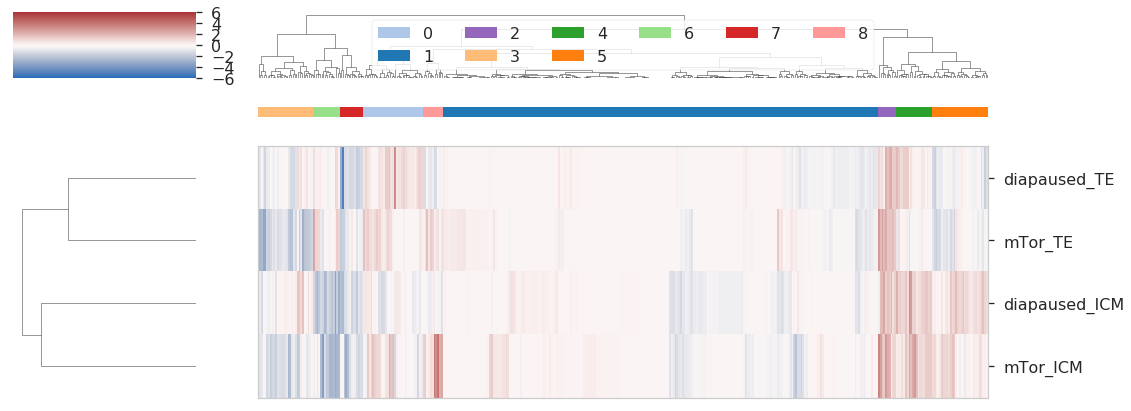

,mean.diapaused_ICM,mean.mTor_ICM,mean.diapaused_TE,mean.mTor_TE,mean_profile,N_tot,N_DE_anyComparison
cluster,,,,,,,
0,-0.127776,0.360500,0.842992,0.534441,discordant,33,0
1,-0.101879,-0.056224,-0.087201,-0.022746,negative,242,0
2,1.436497,1.964691,1.466011,2.018700,positive,10,2
3,0.152812,-1.074550,-0.357441,-1.641778,discordant,31,3
4,1.452468,1.320279,0.681914,-0.089586,discordant,20,0
5,0.872394,0.615255,-0.453685,-0.520024,discordant,31,0
6,-2.004892,-1.881711,0.036030,0.463580,discordant,15,0
7,-1.282754,-1.184942,-1.704106,-0.637479,negative,13,1
8,-0.345574,1.934089,-0.662244,0.751572,discordant,11,1


In [182]:
savefig_file = outputdir_IVV / "heatmap_raw-logFC.svg"
#savefig_file = None


IVV_clusters.plot_heatmap(col_linkage=linkage,
                          savefigfile=savefig_file,
                          #my_cmap=my_cmap,
                          kwargs_heatmap={'vmin':VMIN_LOGFC,'vmax':VMAX_LOGFC}
                          )


summary_table = IVV_clusters.summarize_clusters(DE_genes=CLUSTERINGS['DESeq2']['IVV']['DE_genes'])
display(summary_table)

In [183]:
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['linkage'] = linkage
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['selected_cluster_labels'] = selected_cluster_labels
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['colors_clusters'] = colors_clusters
CLUSTERINGS['DESeq2'][sample_tissue]['CLUSTERINGS'][f'hc_{method}']['summarized_clusters'] = summary_table.copy()

### Export

In [184]:
# This exports the table used for the heatmap ; the sub-table per cluster ; the summary table.
IVV_clusters.export_data(outputdir_IVV, suffix='raw_logFC')

# We also export the scaled logFC values
outputdir_IVV_scaled_tbl = outputdir_IVV / "table_scaled_logFC_for_clustering.tsv"
CLUSTERINGS['DESeq2']['IVV']['scaled_logFC'].to_csv(outputdir_IVV_scaled_tbl,
                                                    header=True,
                                                    index=True,
                                                    sep="\t"
                                                   )

# And the table of DE miRNAs, aggregated from the different comparisons.
outputdir_IVV_DE_genes = outputdir_IVV / "table_DE_genes_all_comparisons.tsv"
CLUSTERINGS['DESeq2']['IVV']['DE_genes_table'].to_csv(outputdir_IVV_DE_genes,
                                                      header=True,
                                                      index=True,
                                                      sep="\t"
                                                     )

../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV/table_w_annotated_clusters.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV/per_cluster_table.raw_logFC/cluster_0.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV/per_cluster_table.raw_logFC/cluster_1.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV/per_cluster_table.raw_logFC/cluster_2.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV/per_cluster_table.raw_logFC/cluster_3.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV/per_cluster_table.raw_logFC/cluster_4.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV/per_cluster_table.raw_logFC/cluster_5.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clustering/2021-07-01_16:43:45/IVV/per_cluster_table.raw_logFC/cluster_6.table.raw_logFC.tsv
../results/RNAseq-DEA_IVV-IVT_clu